# Trump vs. Clinton 2016
## Analyze the sentiments towards Trump and Hillary on r/politics in the months leading up to the 2016 Presidential Election

In [1]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, DecimalType
from pyspark.sql.functions import *
from operator import add

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
97,application_1671409217564_0119,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.


In [2]:
keyWords = ['trump', 'clinton']

In [3]:
filePath = 'abfs://dda-2022-12-15t21-04-18-212z@ddasta.dfs.core.windows.net/reddit/2016/'
months = ['RC_2016-09.bz2', 'RC_2016-10.bz2', 'RC_2016-11.bz2']
dfs = {}


schema = StructType([
    StructField('subreddit', StringType(), nullable=True),
    StructField('score', LongType(), nullable=True),
    StructField('body', StringType(), nullable=True)
])

for month in months:
    path = filePath + month
    dfs[month] = spark.read.json(path, schema=schema).filter(col("subreddit") == "politics")


dfs['RC_2016-09.bz2'].printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- score: long (nullable = true)
 |-- body: string (nullable = true)

In [4]:
filteredDfs = {}

for key, df in dfs.items():
    filteredDfs[key] = {}
    filteredDfs[key]['trump'] = df.filter(col("body").contains("trump"))
    filteredDfs[key]['clinton'] = df.filter(col("body").contains("clinton"))

In [5]:
import spacy

nlp = spacy.load("en_core_web_md")

In [6]:
def sentimentScore (body, keyWord):
    
    if (not nlp.has_pipe("spacytextblob")):
        from spacytextblob.spacytextblob import SpacyTextBlob
        nlp.add_pipe("spacytextblob")
    
    doc = nlp(body)
    sentenceList = list(doc.sents)
    
    sentencesOccuredIn = 0
    sentimentSum = 0
    
    for sent in list(doc.sents):
        sentence = str(sent)
        doc1 = nlp(str(sentence))
        sentiment = doc1._.blob.polarity
        sentencesOccuredIn += 1
        sentimentSum += sentiment

    if (sentencesOccuredIn == 0):
        return 0.0
    if (sentimentSum == 0):
        return 0.0
    
    return sentimentSum/sentencesOccuredIn

sentimentScoreUDF = udf(sentimentScore, returnType=StringType())

In [7]:
monthlyStatistic = {}

for year, dataframes in filteredDfs.items():
    outputDict = {}
    for filterKey, filteredDf in dataframes.items():
        intermediatedf = filteredDf.withColumn("filterString", lit(filterKey))
        outputRow = intermediatedf\
                            .withColumn("sentimentScore", sentimentScoreUDF(intermediatedf.body, intermediatedf.filterString))\
                            .agg(avg(col("sentimentScore")))\
                            .collect()
        outputDict[filterKey] = outputRow
    monthlyStatistic[year] = outputDict

In [9]:
print(monthlyStatistic)

{'RC_2016-09.bz2': {'trump': [Row(avg(sentimentScore)=0.03812410072076036)], 'clinton': [Row(avg(sentimentScore)=0.043643292326045496)]}, 'RC_2016-10.bz2': {'trump': [Row(avg(sentimentScore)=0.03889988143939544)], 'clinton': [Row(avg(sentimentScore)=0.04441560290379396)]}, 'RC_2016-11.bz2': {'trump': [Row(avg(sentimentScore)=0.04071476913645117)], 'clinton': [Row(avg(sentimentScore)=0.044175433491211724)]}}

### The notebook and Azure cluster were shutdown after running the above analysis, so the sentiment scores are copied below for the visualization

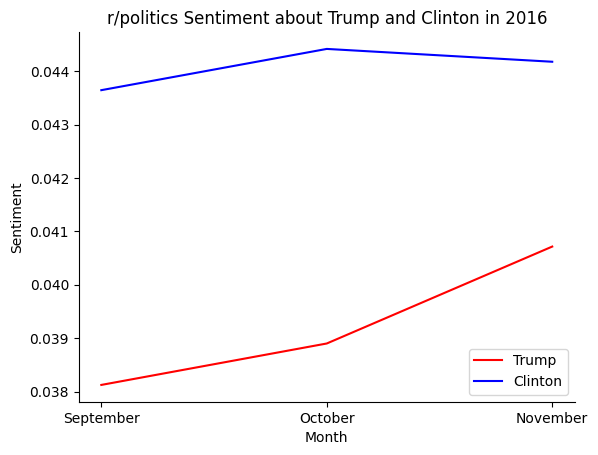

In [2]:
import matplotlib.pyplot as plt

trump_scores = [0.03812410072076036, 0.03889988143939544, 0.04071476913645117]
clinton_scores = [0.043643292326045496, 0.04441560290379396, 0.044175433491211724]

plt.plot(trump_scores, label="Trump", color="red")
plt.plot(clinton_scores, label="Clinton", color="blue")

plt.xlabel("Month")
plt.ylabel("Sentiment")
plt.title("r/politics Sentiment about Trump and Clinton in 2016")

plt.xticks([0, 1, 2], ["September", "October", "November"])

plt.legend()

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

## Analysis:

Our sentiment analysis shows that while r/politics commenters preferred Clinton over Trump, there was actually an increase in Trump's sentiment score from September to October and an even bigger increase between October and November. While Clinton also had an increase in sentiment between September and October, she had a decrease between October and November, though her sentiment score was still much higher than Trump's.

One possible reason for this is because statements such as "Trump won" and "Clinton lost" could be effecting the sentiment score even though they are statements of fact and not opinion or feeling. It is also possible that even people who supported Clinton wanted to be optimistic about Trump after he won the electoin and to give him a chance, even if they did not like him during the election.
